In [ ]:
# Nate Brunacini, nbrunaci@u.rochester.edu
# Supervisor: Kelly A. Douglass
# This file calculates the metallicity gradient values in each galaxy in the data table in the 2018 Pilyugin et al. paper
# and compares them to the values from that paper.

In [1]:
from findmetallicities_Pilyugin import *
import time
from astropy.table import Table
import os

from scatterplotgenerator_Pilyugin import *
from astropy.io import ascii

/home/nbrunaci/.local/lib/python3.9/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR15
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [2]:
# Getting list of plateifus used in Pilyugin et al. paper

paperdata = Table.read('Pilyugin_Paper_Data.txt',format='ascii')
plateifus = []
r25s = paperdata['R25_arcmin']
paper_gradients = paperdata['gradient_OH']
paper_intercepts = paperdata['metallicity']
for i in range(0,len(paperdata)):
    plateifus.append(str(paperdata['plate'][i]) + '-' + str(paperdata['ifu'][i]))
#     r25s.append(paperdata['R25_arcmin'][i])
#     paper_gradients.append(paperdata['gradient_OH'][i])

In [3]:
# Modified from metallicities_iterator_Pilyugin

# Obtaining redshift data from drpall fits file
with fits.open('drpall-v2_4_3.fits', memmap=True) as drpall:
    data = drpall[1].data
    
    exceptions = 0# Number of galaxies for which data could not be retrieved
    start = time.time()
    for plateifu in plateifus:
#     for index in range(1,100):
        try:#for i in range(0,1):#
            # Calculating metallicities
            objmaps = addDiagnostics_Pilyugin(plateifu)
            results = findMetallicities_Pilyugin(objmaps)
            
            # Preparing layers of data values
            header = fits.PrimaryHDU([])
            R_hdu = fits.ImageHDU(results['R']['metallicity'].data, name='R_metallicity')
            R_ivar_hdu = fits.ImageHDU(results['R']['ivar'].data, name='R_ivar')# Left blank as ivar methods are not yet implemented
            
            # Preparing layers of mask values; ImageHDU apparently cannot be used for boolean values, so mask values are 
            # converted to integers here
            R_m_hdu = fits.ImageHDU(results['R']['metallicity'].mask.astype('int32'), name='R_mask')
            
            # Saving data and mask layers to FITS file
            hdul = fits.HDUList([header, R_hdu, R_ivar_hdu, R_m_hdu])
            filename = 'Pilyugin_Galaxy_FITS/Pilyugin_'+plateifu+'.fits'
            # Removing existing file to allow new one to be saved
            if os.path.exists(filename):
                os.remove(filename)
            hdul.writeto(filename)
            
        except Exception:
            exceptions += 1
            print(index)
    end = time.time()
    print('Number of galaxies for which data could not be retrieved: ' + str(exceptions))
    print('Elapsed time: ' + str(end - start))

[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in double_scalars (RuntimeWarning)
[WARNING]: invalid value encountered in double_scalars (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)


Number of galaxies for which data could not be retrieved: 0
Elapsed time: 533.3411705493927


In [5]:
# Number of galaxies for which data could not be retrieved: 0
# Elapsed time: 533.3411705493927

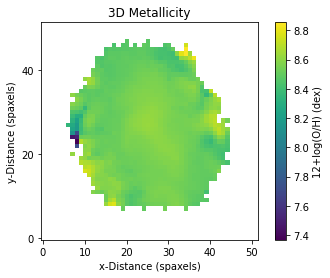

In [6]:
with fits.open('Pilyugin_Galaxy_FITS/Pilyugin_7443-6103.fits', mode='update') as hdul:
    maskeddata = ma.masked_where(hdul[3].data==1, hdul[1].data)
    plt.imshow(maskeddata)#,vmin=8.5,vmax=9.5)
    plt.gca().invert_yaxis()
    plt.locator_params(axis='y', nbins=5)
    plt.title('3D Metallicity')
    plt.xlabel('x-Distance (spaxels)')
    plt.ylabel('y-Distance (spaxels)')
    plt.colorbar(label='12+log(O/H) (dex)')

In [7]:
# Modified from scatterplot_iterator_Pilyugin

params_list = []
total_galaxies = 0
successes = 0# Number of galaxies for which data was available
exceptions = 0# Number of galaxies for which data was not available

with fits.open('drpall-v2_4_3.fits', memmap=True) as drpall:
    for i in range(0,1):# Temporary; just to fix indentation issue quickly
        data = drpall[1].data
        c_table = Table.read('DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_noWords_v5.txt',format='ascii.commented_header')
        start = time.time()
#         for index in range(0,len(data['plateifu'])):# Use this to iterate over every galaxy
#         for index in range(0,1):
        paper_index = 0
        for plateifu in plateifus:
            total_galaxies += 1
            try:
#             for i in range(0,1):# For testing only
                #plateifu = data['plateifu'][index]
                plate,ifu = plateifu.split('-')
                fit_parameters = find_gradient(plateifu,data,c_table)
                Rp = fit_parameters['R_params']
                addition= [plateifu,Rp.slope,Rp.intercept,Rp.rvalue,Rp.pvalue,Rp.stderr,Rp.intercept_stderr,
                          Rp.slope*fit_parameters['r50']/(r25s[paper_index]*60)]# Factor of 60 converts from arcmin to arcsec
                with open('FitParameters_Pilyugin_Comparer.txt','a') as param_file:
                    param_file.write('\n')
                    for element in addition:#params_list[len(params_list)-1]:
                        param_file.write(str(element) + ' ')
#                     param_file.write('\n' + str(params_list[len(params_list)-1]))
                successes += 1
            except Exception:
                exceptions += 1
            paper_index += 1
        end = time.time()
        print('Number of galaxies for which data could not be retrieved:',str(exceptions))
        print('Elapsed time:',str(end - start))
        # Checking for issues
        if not exceptions+successes == total_galaxies:
            print('Exceptions+successes does not equal total_galaxies')

[WARNING]: OverflowError converting to FloatType in column avg_alpha, possibly resulting in degraded precision. (AstropyWarning)
[WARNING]: OverflowError converting to FloatType in column pos_alpha, possibly resulting in degraded precision. (AstropyWarning)
[WARNING]: OverflowError converting to FloatType in column neg_alpha, possibly resulting in degraded precision. (AstropyWarning)


Number of galaxies for which data could not be retrieved: 0
Elapsed time: 10.767720460891724


In [8]:
# Count how many galaxies have negative trend line slopes for R and output their index, plateifu, and slope

with open('FitParameters_Pilyugin_Comparer.txt','r') as param_file:
    header = param_file.readline()
    count = 0# Number of galaxies with negative slope
    large_negatives = 0# Number of galaxies with slope less than -0.1
    large_negatives_plateifu = []
    for index in range(1,48):
        line = param_file.readline().split(' ')
        if float(line[7]) < 0:
            count += 1
#             print('Index:',line[0])
#             print('Plateifu:',line[1])
#             print('Slope:',line[2]+'\n')
            if float(line[7]) < -0.1:
                large_negatives += 1
                large_negatives_plateifu.append(line[1])
    print('Number of galaxies with negative slope:',count)
    print('Fraction of galaxies with negative slope:',count/47)
#     print('Number of galaxies with slope less than -0.1:',large_negatives)
#     print('Fraction of galaxies with slope less than -0.1:',large_negatives/4717)
#     print(large_negatives_plateifu)

Number of galaxies with negative slope: 44
Fraction of galaxies with negative slope: 0.9361702127659575


-1.3261954101150633
0.04436368059766182


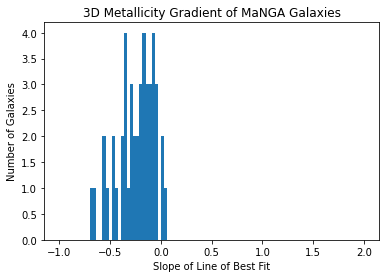

In [9]:
# Create histogram of slopes for R metallicity method

data = ascii.read('FitParameters_Pilyugin_Comparer.txt')
R_slope = data.columns['R_slope']

print(min(R_slope))
print(max(R_slope))

plt.hist(R_slope,bins=np.linspace(-1,2,100))#,bins,alpha=0.5,weights=weights[3],label='SDSS DR7',color='gray',density=True)
plt.xlabel('Slope of Line of Best Fit')
plt.ylabel('Number of Galaxies')
plt.title('3D Metallicity Gradient of MaNGA Galaxies')
plt.savefig('PosterMaps_Updated/SlopeHistogram_R_PaperGalaxies')
# plt.close()

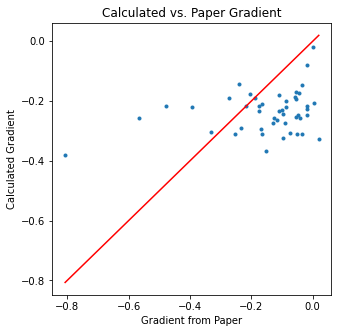

In [4]:
# Scatter plots of calculated gradient versus paper's gradient values

calculated = Table.read('FitParameters_Pilyugin_Comparer.txt',format='ascii')
fig, plots = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(5)
plots.plot(calculated['R_slope_normalizedByR25'],paper_gradients,'.')
plots.set_title('Calculated vs. Paper Gradient')
plots.set_ylabel('Calculated Gradient')
plots.set_xlabel('Gradient from Paper')
x = np.linspace(min([min(calculated['R_slope_normalizedByR25']),min(paper_gradients)]),
                max([max(calculated['R_slope_normalizedByR25']),max(paper_gradients)]))
plots.plot(x,x,'-r')
plt.savefig('PosterMaps_Updated/Pilyugin_Gradient_Comparison')
# plt.savefig('Pilyugin_Galaxy_ScatterPlots/'+plateifu+'ScatterPlot_R')
# plt.close()

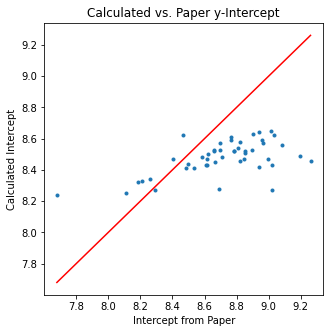

In [5]:
# Scatter plots of calculated y-intercept versus paper's y-intercept values

calculated = Table.read('FitParameters_Pilyugin_Comparer.txt',format='ascii')
fig, plots = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(5)
plots.plot(calculated['R_intercept'],paper_intercepts,'.')
plots.set_title('Calculated vs. Paper y-Intercept')
plots.set_ylabel('Calculated Intercept')
plots.set_xlabel('Intercept from Paper')
x = np.linspace(min([min(calculated['R_intercept']),min(paper_intercepts)]),
                max([max(calculated['R_intercept']),max(paper_intercepts)]))
plots.plot(x,x,'-r')
plt.savefig('PosterMaps_Updated/Pilyugin_Intercept_Comparison')